In [2]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import scipy.stats as ss

group1 = np.array([3, 1, 2])
group2 = np.array([5, 3, 4])
group3 = np.array([7, 6, 5])

def common_average(*args):
    """
    Принимает на вход произвольное число выборок и находит общее среднее всех групп.
    """
    return sum([sum(i) / len(i) for i in args]) / len(args)


def sst(*args):
    """
    Sum squares total, Общая сумма квадратов.
    Так как для вычисления общей суммы квадратов нам надо знать хотя бы 
    N элементов, число степеней свободы df = N - 1,
    где N общее число элементов во всех группах.
    """
    x = common_average(*args)
    return sum([sum((i - x) ** 2) for i in args])


def ssw(*args):
    """
    Внутригрупповая сумма квадратов (Sum Squares Within)
    Так как в данном случае нам надо знать только по n - 1 элементу из 
    каждой группы, число степеней свободы df = N - m,
    где m - количество групп.
    """
    return sum([sum((i - np.mean(i)) ** 2) for i in args])

def ssb(*args):
    """
    Межгрупповая сумма квадратов (Sum Squares Between)
    Показывает на сколько групповые средние отклоняются от общего среднего.
    Нам достаточно df = m - 1 групповых средних, чтобы расчитать этот показатель,
    где m - число групп.
    """
    x = common_average(*args)
    return sum([len(i) * (np.mean(i) - x) ** 2 for i in args])


In [3]:
def plot_dencity(data):
    sns.set(rc={'figure.figsize':(8, 8)})
    sns.kdeplot(data)

In [8]:
"""
Сравним 3 группы с помощью дисперсионного анализа.
Н0: mu1 = mu2 = mu3
H1: mu1 != mu2 != mu3 (хотя бы пара средних значимо различается)
"""
# Сначала найдем общую сумму квадратов всех групп
x = common_average(group1, group2, group3) # общее среднее всех групп
SST = sst(group1, group2, group3)

"""
SST состоит из внутригрупповой суммы квадратов (Sum Squares Within) и межгрупповой
суммы (Sum Squares Between). SST = SSW + SSB
SSW объясняет изменчивость внутри групп, а SSB объясняет изменчивость между группами.
"""
SSW = ssw(group1, group2, group3)
SSB = ssb(group1, group2, group3)


In [9]:
"""
Общая изменчивость объяняется межгрупповой и внутригрупповой.
Теперь выясним какой из них в большей степени с помощью F-критерия.
"""
def df_ssw(*args):
    """
    Так как в данном случае нам надо знать только по n - 1 элементу из 
    каждой группы, число степеней свободы df = N - m,
    где m - количество групп.
    """
    return sum([len(i) for i in args]) - len(args)

def df_ssb(*args):
    """
    Нам достаточно df = m - 1 групповых средних, чтобы расчитать этот показатель,
    где m - число групп.
    """
    return len(args) - 1


df_SSW = df_ssw(group1, group2, group3)
df_SSB = df_ssb(group1, group2, group3)
F = (SSB / df_SSB) / (SSW / df_SSW)
"""
Интерпретация:
Предположим, что из одной генеральной совокупности, мы бы всегда выбирали 3 выборки,
и расчитывали каждый раз расчитывали F-критерий, тогда они бы распределились по
F - распределению и мы бы смогли посмотреть вероятность получения подобных  
отклонений. Так как выборки сделаны из одной генеральной совокупности, то 
SSB стремится к нулю, и F стремится к нулю.
"""
import scipy.stats as ss
p_value = 1-ss.f.cdf(F, df_SSB, df_SSW)
print(p_value)

0.6861482044365153


In [10]:
def count_f(*args):
    SSW = ssw(*args)
    SSB = ssb(*args)
    df_SSW = df_ssw(*args)
    df_SSB = df_ssb(*args)
    return (SSB / df_SSB) / (SSW / df_SSW)

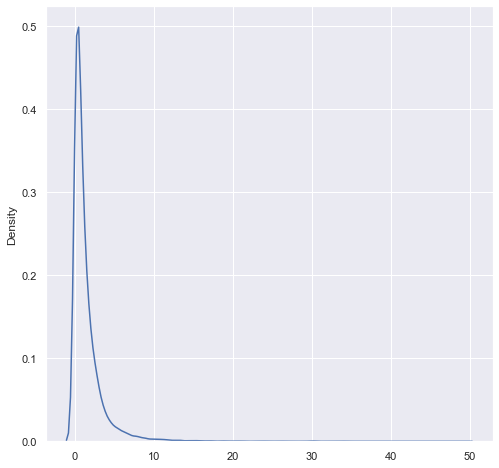

In [13]:
# Пример F-распределения Фишера
data = np.random.normal(loc = 10, scale = 2, size = 1000)
n = 3
result = []

for i in range(10000):
    group1 = np.random.choice(data, n, replace=False)
    group2 = np.random.choice(data, n, replace=False)
    group3 = np.random.choice(data, n, replace=False)
    result.append(count_f(group1, group2, group3))
plot_dencity(result)


In [11]:
"""
Генотерапия позволяет корректировать работу дефективного гена, отвественного
за различные заболевания. В эксперименте сравнивалась эффективность 4-х
различных типов терапии.
"""
expr = np.array(map(int,'100 96 101 95 103 99 97 96 98 106 106 104 95 95 105 100 100 95 84 101 101 95 106 105 97 103 94 94 100 107 91 96 94 96 91 85 98 93 100 85 101 101 90 98 97 92 85 95 89 91 91 99 94 97 94 87 93 96 92 90'.split(" ")))
therapy = np.array('A A A A A A A A A A A A A A A B B B B B B B B B B B B B B B C C C C C C C C C C C C C C C D D D D D D D D D D D D D D D'.split(' '))
df = pd.DataFrame({'expr': expr,
              'Therapy': therapy})

group_averages = df.groupby("Therapy").mean()

In [12]:
groups_amount = len(set(df.Therapy))
common_amount =len(df)
mean_common = df.expr.mean()
SST = sum((df.expr - mean_common) ** 2)
group_means = df.groupby("Therapy").mean()
group_means.rename(columns = {'expr': 'means'}, inplace = True )
df = pd.merge(df, group_means, on='Therapy')
SSW = sum((df.expr - df.means) ** 2)
df = df.groupby("means").count()
df["means"] = df.index
SSB = sum(df.expr * (df.means - mean_common) ** 2)
df_SSW = common_amount - groups_amount
df_SSB = groups_amount - 1
F = (SSB / df_SSB) / (SSW / df_SSW)
p_value = 1-ss.f.cdf(F, df_SSB, df_SSW)
print(p_value)

0.00015249722895227524


96.31666666666666


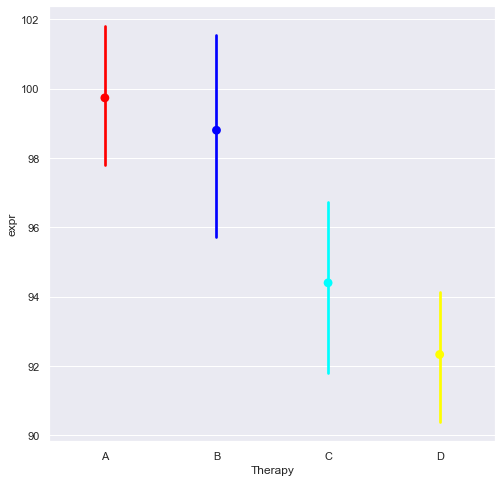

In [19]:
expr = np.array(map(int,'100 96 101 95 103 99 97 96 98 106 106 104 95 95 105 100 100 95 84 101 101 95 106 105 97 103 94 94 100 107 91 96 94 96 91 85 98 93 100 85 101 101 90 98 97 92 85 95 89 91 91 99 94 97 94 87 93 96 92 90'.split(" ")))
therapy = np.array('A A A A A A A A A A A A A A A B B B B B B B B B B B B B B B C C C C C C C C C C C C C C C D D D D D D D D D D D D D D D'.split(' '))
df = pd.DataFrame({'expr': expr,
              'Therapy': therapy})

sns.pointplot(x = df.Therapy, y = df.expr, data = df, dodge=True, linestyles=['', ''], palette=['red', 'blue', 'cyan', 'yellow'])
print(mean_common)